<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2019 </h1>

<H3 align='center'> Tarea 3 - Ensamblados y modelos avanzados </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Técnicas de ensamblado: *bagging*, *boosting* y *random forest*.
* Ventajas de técnicas de ensamblados
* Problemas desbalanceados
 

**Formalidades**  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y cierre competencia: 17 de Enero
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF393-II-2019]

<hr style="height:2px;border:none"/>


[1.](#primero) Ensamblados para regresión  

<a id="primero"></a>
## 1. Ensamblados para regresión
---
Las técnicas de ensamblados vistos en clases pueden ser aplicadas tanto a problemas de clasificación o regresión, teniendo la ventaja de utilizar múltiples modelos de aprendizaje para utilizar la ventaja de cada uno. En este actividad se trabajará con predecir la temperatura media de un día, dada cierta información del día anterior, como la humedad, velocidad del viento, presión atmosférica, fecha y temperatura. El modelo predictor derivado puede ser bastante útil para conocer el comportamiento del clima a lo largo del tiempo.

<img src="https://scijinks.gov/review/forecast-reliability/forecast-reliability2.jpg" title="Title text" width="70%"  />

Los datos de clima son recolectados en la ciudad Delhi de India por un período de 4 años (2013 a 2017), proporcionados en Kaggle a través del siguiente __[link](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data)__, las particiones de entrenamiento y prueba están dadas. El registro de cada dato corresponde a un día, incrementando a través de las filas por cada día.

---
    
>  Cargue los datos en un dataframe de pandas, además agregue una columna indicando el valor a predecir, la temperatura media del día siguiente. *Como el último dato/registro no tiene un valor a predecir éste se elimina*.
```python
import pandas as pd
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row
```

> Debido a la poca información que se tiene a través de los 4 parámetros medidos, extraíga más información a través de los datos de fecha. Por ejemplo, el comportamiento a través de los meses y años varía, así como la información de la temporada del año podría ayudar a la predicción. Decida si puede incluir más información a partir de la fecha que tenga sentido con el problema.
```python
...#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
...#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
... #any more information?
df.drop(["date"], axis=1, inplace=True) #delete date
```

> Cree las matrices de entrenamiento, con los mil primeros registros, y de validación, con el resto. Para evitar el orden natural en que vienen los datos entrenados, realice un *shuffle* aleatorio.
```python
y = df.pop("y_value").values
X = df.values 
X_train = X[:1000]
y_train = y[:1000]
X_val = X[1000:]
y_val = y[1000:]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0) #shuffle values on train only
```

> a) Describa el problema trabajado, la cantida de datos que se cuenta como las características a trabajar. Al ser datos temporales podría ayudar una ilustración gráfica de la secuencias trabajadas y su comportamiento ¿Es válido el uso de la información sólo del día anterior?.


> b) Entrene un solo Árbol de Regresión de múltiples niveles para resolver el problema. Defina un Árbol **no regularizado** (como el que no tiene límites en su profundidad) y otro Árbol **regularizado** (variando los hiper-parámetros que prefiera, por ejemplo, los más comunes como la profundidad, el número mínimo de datos para realizar *split* o el número mínimo de datos en cada hoja). Además comente sobre la ventaja de usar un árbol de decisión respecto a la escala de los datos ¿Porqué no es necesario escalar los datos?
```python
import numpy as np
def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )
from sklearn.tree import DecisionTreeRegressor as Tree
model_unr = Tree() #unregularized model -- default parameters
model_unr.fit(X_train,y_train)
... #define your regularized tree model
``` 

> c) Para evaluar la calidad de predicción en este problema se utilizará la métrica *Root Mean Squared Error* (RMSE), indicando un error en la escala real de la temperatura. Como los datos de validación siguen con el orden temporal, visualice esa predicción a lo largo del tiempo. Comente sobre los resultados comparando la regularización *vs* el no regularizar.
```python
y_train_hat = model.predict(X_train)
y_val_hat = model.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()
```
    
> d) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de **Bagging**, compare el Árbol **no regularizado** con el **regularizado** (*seteando los hiper-parámetros en base a lo experimentado anteriormente en b)*) ¿Qué debería suceder? ¿Se visualiza *overfitting*? Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.
```python
from sklearn.ensemble import BaggingRegressor
model = BaggingRegressor(base_estimator=Tree(...), n_estimators=..., n_jobs=-1)
```

> e) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de **AdaBoost**, compare el Árbol **no regularizado** con el **regularizado** (*seteando los hiper-parámetros en base a lo experimentado anteriormente en d)* ¿Se visualiza *overfitting*? ¿Qué técnica utiliza la librería de sklearn, *re-muestrear* o *pesar* ejemplos? ¿Qué le parece más sensato?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro. Compare y analice con la técnica utilizada en d).
```python
from sklearn.ensemble import AdaBoostRegressor
model = AdaBoostRegressor(base_estimator=Tree(...), n_estimators=...)
```

> f) Pruebe otra técnica de ensamblado dedicada a árboles de decisión, que combina el muestreo *boostrap* de *Bagging* con muestreo sobre las *features*: **Random Forest**, compare el Árbol **no regularizado** con el **regularizado** ¿Se visualiza *overfitting*?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.
```python
from sklearn.ensemble import RandomForestRegressor
model_unr = RandomForestRegressor(n_estimators=..., n_jobs=-1)
... #define your regularized random forest model
```

> g) Verifique que el **OOB error** (*out of bag error*) de los ensambladores que utilizan la técnica *boostrap* puede ser una alternativa como métrica de generalización, compare con el error calculado sobre el conjunto de validación (o en su defecto *cross validation*).
```python
oob_error = model.oob_score_
val_error = model.score(X_val,y_val)
print("OOB error: ",oob_error)
print ("Val error: ",val_error)
```

> h) Defina otra forma de combinar los valores que entregan los ensamblados al hacer predicciones y compare con lo que se hace actualmente, por ejemplo *Bagging* realiza el voto de la mayoría para clasificación y promedio para regresión, *AdaBoost* realiza una combinación ponderada de cada clasificador dependiendo de su *habilidad* (desempeño para clasificar el conjunto de entrenamiento). Se puede inspirar desde clásicos estadísticos, como entregar el primer cuartíl ($Q_1$) si al ensamblado le cuesta predecir valores bajos, o el segundo cuartil ($Q_2$) o mediana para ser robusto a predicciones atípicas de modelos.  
```python
def combine_predictions(predictions):
    return #define !
list_estimators = model.estimators_
list_predictions = [estimator.predict(X_val) for estimator in list_estimators]
new_predictions = combine_predictions(list_predictions)
print("RMSE val= ",RMSE(y_val, new_predictions))
```

> i) Si se cuenta con una gran cantidad de modelos en el ensamblado, por ejemplo $T>100$, se puede crear un intervalo de confianza de la predicción a través de todos estos valores, asumiendo una distribución Normal centrada en la media muestral de las predicciones, con desviación estándar muestral en las predicciones. El intervalo de confianza entrega más información que un único valor puntual de predicción. Visualice un intervalo de confianza al 95% de probabilidad en la predicción a lo largo de la serie de tiempo de validación, comente. Al asumir una distribución Normal, también puede explorar el tomar como predicción del ensamblado el muestreo sobre la distribución Normal creada entorno a los datos muestrales.
```python
X_val_est = np.vstack(list_predictions).T #has shape=(N_test, n_estimator), with n_estimator>100
from scipy.stats import norm
interv_val = []
for n in range(X_val.shape[0]):
    low, up = norm.interval(0.95, loc=np.mean(X_val_est[n]), scale=np.std(X_val_est[n]))
    interv_val.append([low,up])
interv_val = np.asarray(interv_val)
x = np.arange(X_val_est.shape[0])
plt.figure(figsize=(8,5))
plt.plot(x, np.mean(X_val_est, axis=1))
plt.fill_between(x, interv_val[:,0], interv_val[:,1], color='r', alpha=.55)
plt.show()
```
    
>  j) Evalúe y visualice la predicción del mejor modelo encontrado para resolver este problema, en el conjunto de pruebas. Además, compare y analice las distintas maneras con las que se resolvió el problema, incluya las decisiones que conlleva y los resultados que reflejan.
```python
df = pd.read_csv("DailyDelhiClimateTest.csv")
```

Cargue los datos en un dataframe de pandas, además agregue una columna indicando el valor a predecir, la temperatura media del día siguiente. *Como el último dato/registro no tiene un valor a predecir éste se elimina*.

In [0]:
import pandas as pd

url_train = 'https://raw.githubusercontent.com/garjona/Tarea3-INF393-II-2019/master/DailyDelhiClimateTrain.csv?token=AFHXMWUE7N4SHFPDSK5AMTK6FEA6W'
df = pd.read_csv(url_train)
url_test = 'https://raw.githubusercontent.com/garjona/Tarea3-INF393-II-2019/master/DailyDelhiClimateTest.csv?token=AFHXMWSXPE4SCIWHBW4M4OC6FEARQ'

In [0]:
if df.empty:
  df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row

Debido a la poca información que se tiene a través de los 4 parámetros medidos, extraíga más información a través de los datos de fecha. Por ejemplo, el comportamiento a través de los meses y años varía, así como la información de la temporada del año podría ayudar a la predicción. Decida si puede incluir más información a partir de la fecha que tenga sentido con el problema.

In [0]:
#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['day'] = df['date'].dt.day
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.week
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
#any more information?
df.drop(["date"], axis=1, inplace=True) #delete date

In [4]:
df.head()

,meantemp,humidity,wind_speed,meanpressure,y_value,cday,day,day_of_year,week_of_year,year,month,season_fall,season_rainy,season_summer,season_winter
0,10.000000,84.500000,0.000000,1015.666667,7.400000,1,1,1,1,2013,1,0,0,0,1
1,7.400000,92.000000,2.980000,1017.800000,7.166667,2,2,2,1,2013,1,0,0,0,1
2,7.166667,87.000000,4.633333,1018.666667,8.666667,3,3,3,1,2013,1,0,0,0,1
3,8.666667,71.333333,1.233333,1017.166667,6.000000,4,4,4,1,2013,1,0,0,0,1
4,6.000000,86.833333,3.700000,1016.500000,7.000000,5,5,5,1,2013,1,0,0,0,1


Cree las matrices de entrenamiento, con los mil primeros registros, y de validación, con el resto. Para evitar el orden natural en que vienen los datos entrenados, realice un *shuffle* aleatorio.

In [0]:
y = df.pop("y_value").values
X = df.values 
X_train = X[:1000]
y_train = y[:1000]
X_val = X[1000:]
y_val = y[1000:]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0) #shuffle values on train only

**a)** Describa el problema trabajado, la cantidad de datos que se cuenta como las características a trabajar. Al ser datos temporales podría ayudar una ilustración gráfica de la secuencias trabajadas y su comportamiento ¿Es válido el uso de la información sólo del día anterior?.

In [6]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure,cday,day,day_of_year,week_of_year,year,month,season_fall,season_rainy,season_summer,season_winter
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,25.506127,60.744851,6.806865,1011.101197,3.000000,15.729637,183.125257,26.626968,2014.501027,6.522930,0.249144,0.251882,0.251882,0.247091
std,7.339416,16.743928,4.559688,180.293335,1.998972,8.803105,105.474746,15.069603,1.118723,3.449884,0.432666,0.434243,0.434243,0.431468
min,6.000000,13.428571,0.000000,-3.041667,0.000000,1.000000,1.000000,1.000000,2013.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,18.857143,50.375000,3.475000,1001.571429,1.000000,8.000000,92.000000,14.000000,2014.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,27.714286,62.625000,6.250000,1008.555556,3.000000,16.000000,183.000000,27.000000,2015.000000,7.000000,0.000000,0.000000,0.000000,0.000000
75%,31.312500,72.125000,9.250000,1014.937500,5.000000,23.000000,274.000000,40.000000,2016.000000,10.000000,0.000000,1.000000,1.000000,0.000000
max,38.714286,98.000000,42.220000,7679.333333,6.000000,31.000000,366.000000,53.000000,2016.000000,12.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dfScaler =  pd.DataFrame(data= scaler.fit_transform(df[df.columns]), columns=df.columns)

In [8]:
dfScaler.describe()

,meantemp,humidity,wind_speed,meanpressure,cday,day,day_of_year,week_of_year,year,month,season_fall,season_rainy,season_summer,season_winter
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,0.596257,0.559483,0.161224,0.132009,0.500000,0.490988,0.498973,0.492826,0.500342,0.502085,0.249144,0.251882,0.251882,0.247091
std,0.224349,0.197986,0.107998,0.023468,0.333162,0.293437,0.288972,0.289800,0.372908,0.313626,0.432666,0.434243,0.434243,0.431468
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.393013,0.436867,0.082307,0.130769,0.166667,0.233333,0.249315,0.250000,0.333333,0.272727,0.000000,0.000000,0.000000,0.000000
50%,0.663755,0.581715,0.148034,0.131678,0.500000,0.500000,0.498630,0.500000,0.666667,0.545455,0.000000,0.000000,0.000000,0.000000
75%,0.773745,0.694046,0.219090,0.132508,0.833333,0.733333,0.747945,0.750000,1.000000,0.818182,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


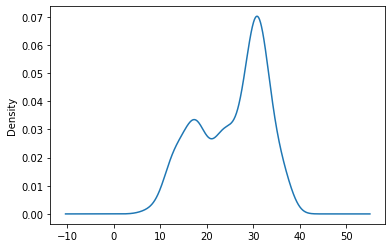

In [9]:
df["meantemp"].plot.kde()

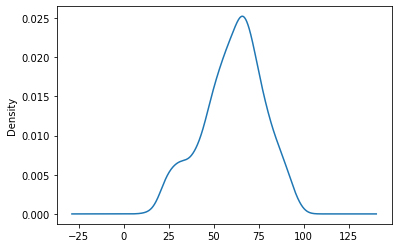

In [10]:
df["humidity"].plot.kde()

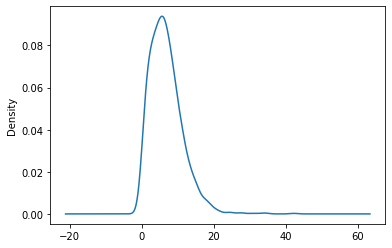

In [11]:
df["wind_speed"].plot.kde()

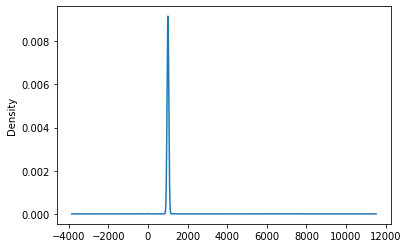

In [12]:
df["meanpressure"].plot.kde()

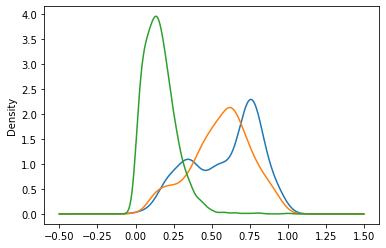

In [13]:
dfScaler["meantemp"].plot.kde()
dfScaler["humidity"].plot.kde()
dfScaler["wind_speed"].plot.kde()

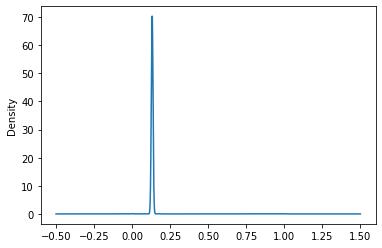

In [14]:
dfScaler["meanpressure"].plot.kde()

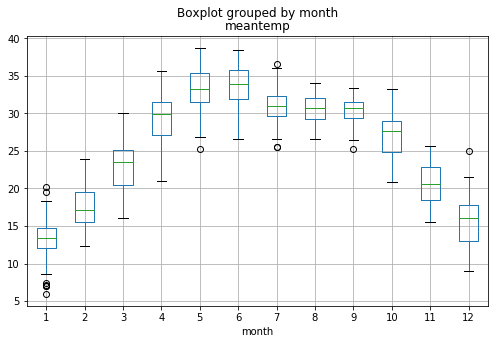

In [15]:
df.boxplot(column=['meantemp'], by= "month" ,figsize=(8,5))

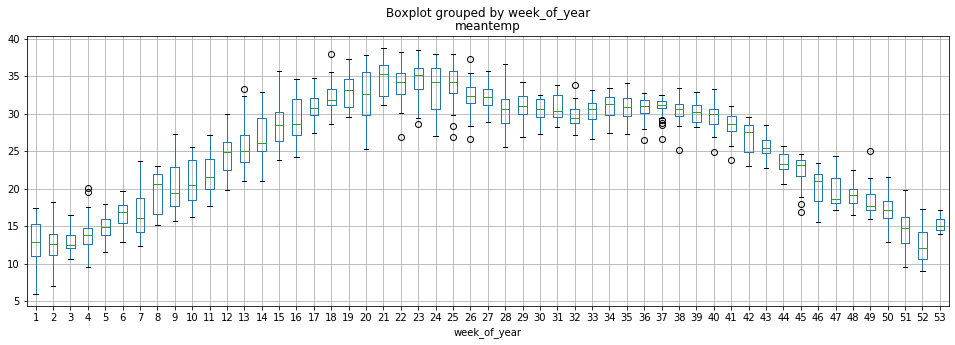

In [16]:
df.boxplot(column=['meantemp'], by= "week_of_year" ,figsize=(16,5))

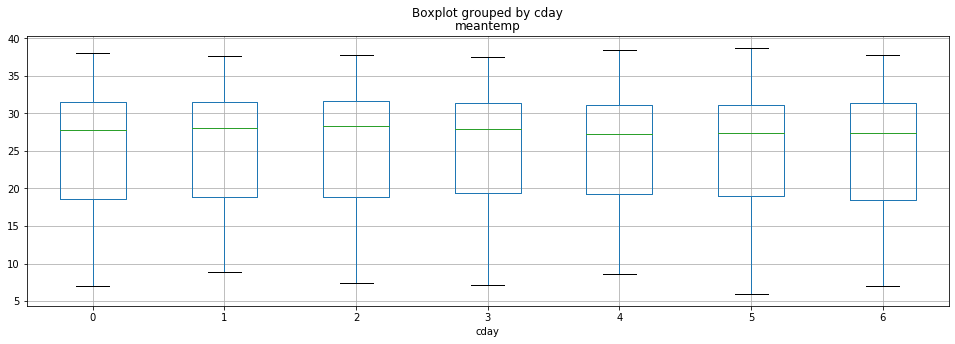

In [17]:
df.boxplot(column=['meantemp'], by= "cday" ,figsize=(16,5))

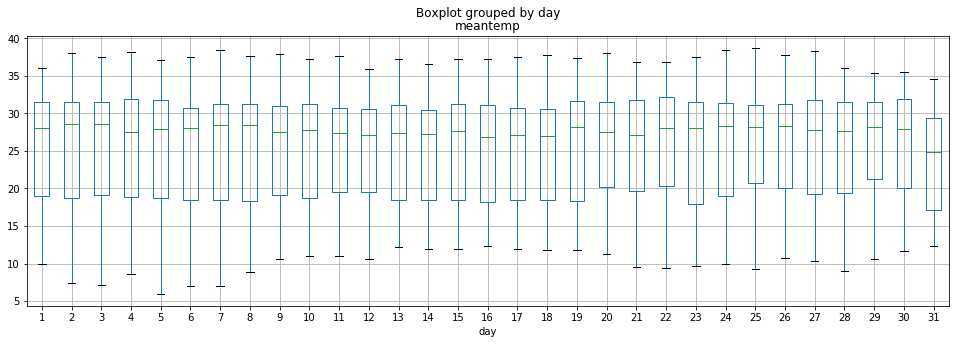

In [18]:
df.boxplot(column=['meantemp'], by= "day" ,figsize=(16,5))

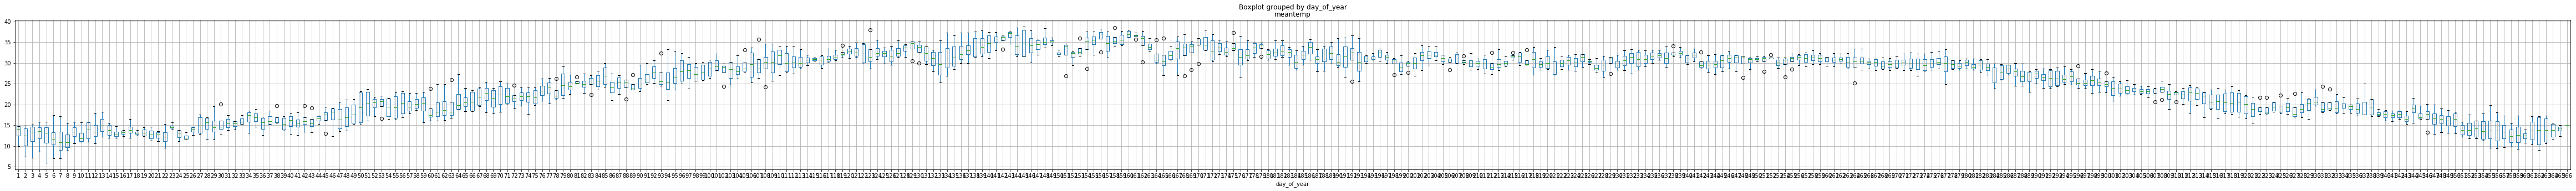

In [19]:
df.boxplot(column=['meantemp'], by= "day_of_year" ,figsize=(80,5))

**b)** Entrene un solo Árbol de Regresión de múltiples niveles para resolver el problema. Defina un Árbol **no regularizado** (como el que no tiene límites en su profundidad) y otro Árbol **regularizado** (variando los hiper-parámetros que prefiera, por ejemplo, los más comunes como la profundidad, el número mínimo de datos para realizar *split* o el número mínimo de datos en cada hoja). Además comente sobre la ventaja de usar un árbol de decisión respecto a la escala de los datos ¿Porqué no es necesario escalar los datos?

In [20]:
import numpy as np

from sklearn.tree import DecisionTreeRegressor as Tree

def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )

# Unregularized model -- default parameters
model_unr = Tree()
model_unr.fit(X_train,y_train)

# Regularized tree model
model_reg = Tree(splitter='best', max_depth=5, min_samples_split=5, max_leaf_nodes=14)
model_reg.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=14,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

**c)** Para evaluar la calidad de predicción en este problema se utilizará la métrica Root Mean Squared Error (RMSE), indicando un error en la escala real de la temperatura. Como los datos de validación siguen con el orden temporal, visualice esa predicción a lo largo del tiempo. Comente sobre los resultados comparando la regularización vs el no regularizar.

> **1) Unregularized**



RMSE train=  0.0
RMSE val=  2.5871868476182946


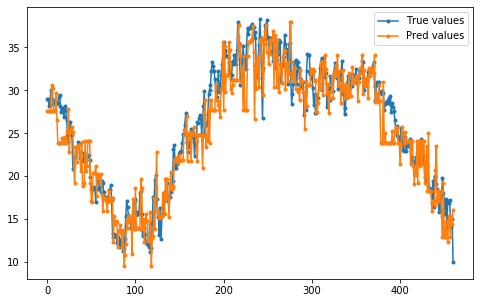

In [21]:
import matplotlib.pyplot as plt

y_train_hat = model_unr.predict(X_train)
y_val_hat = model_unr.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))

plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()

**2) Regularized**

RMSE train=  1.6612681497646349
RMSE val=  1.6878041253762064


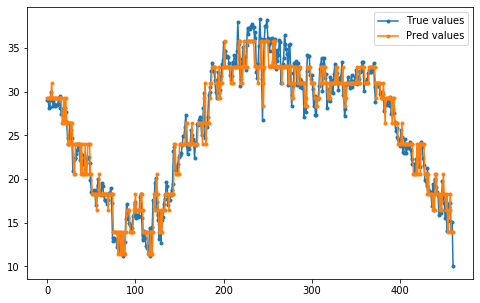

In [22]:
y_train_hat = model_reg.predict(X_train)
y_val_hat = model_reg.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))

plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()

**d)** Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de Bagging, compare el Árbol no regularizado con el regularizado (seteando los hiper-parámetros en base a lo experimentado anteriormente en b)) ¿Qué debería suceder? ¿Se visualiza overfitting? Varíe la cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.

**1) Unregularized**

In [0]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import BaggingRegressor

RMSE_train_list = []
RMSE_test_list = []

for n_estimator in range(100):

  # to avoid n_estimator = 0
  n_estimator = n_estimator + 1

  model = BaggingRegressor(base_estimator=model_unr, n_estimators=n_estimator, n_jobs=-1)
  model.fit(X_train,y_train)

  y_train_hat = model.predict(X_train)
  y_val_hat = model.predict(X_val)
  RMSE_train_list.append(RMSE(y_train,y_train_hat))
  RMSE_test_list.append(RMSE(y_val,y_val_hat))

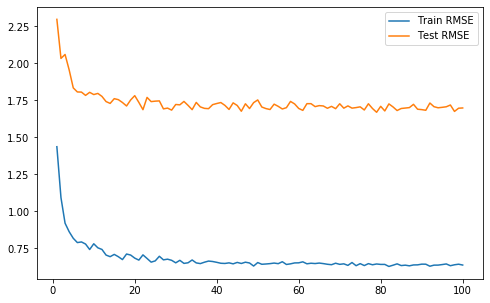

In [24]:
x_axis = np.arange(101)[1:]
plt.figure(figsize=(8,5))
plt.plot(x_axis, RMSE_train_list,label="Train RMSE")
plt.plot(x_axis, RMSE_test_list,label="Test RMSE")
plt.legend()
plt.show()

**2) Regularized**

In [0]:
RMSE_train_list = []
RMSE_test_list = []

for n_estimator in range(100):

  # to avoid n_estimator = 0
  n_estimator = n_estimator + 1

  model = BaggingRegressor(base_estimator=model_reg, n_estimators=n_estimator, n_jobs=-1)
  model.fit(X_train,y_train)

  y_train_hat = model.predict(X_train)
  y_val_hat = model.predict(X_val)
  RMSE_train_list.append(RMSE(y_train,y_train_hat))
  RMSE_test_list.append(RMSE(y_val,y_val_hat))

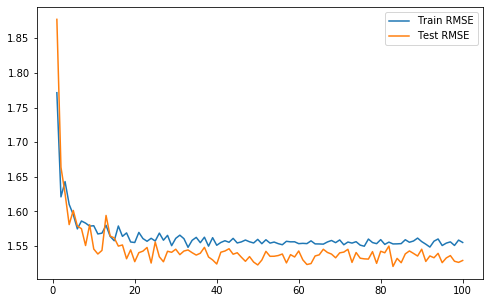

In [26]:
x_axis = np.arange(101)[1:]
plt.figure(figsize=(8,5))
plt.plot(x_axis, RMSE_train_list,label="Train RMSE")
plt.plot(x_axis, RMSE_test_list,label="Test RMSE")
plt.legend()
plt.show()

**e)** Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de AdaBoost, compare el Árbol no regularizado con el regularizado (seteando los hiper-parámetros en base a lo experimentado anteriormente en d) ¿Se visualiza overfitting? ¿Qué técnica utiliza la librería de sklearn, re-muestrear o pesar ejemplos? ¿Qué le parece más sensato?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro. Compare y analice con la técnica utilizada en d).

**1) Unregularized**

In [0]:
from sklearn.ensemble import AdaBoostRegressor

RMSE_train_list = []
RMSE_test_list = []

for n_estimator in range(100):

  # to avoid n_estimator = 0
  n_estimator = n_estimator + 1

  model = AdaBoostRegressor(base_estimator=model_unr, n_estimators=n_estimator)
  model.fit(X_train,y_train)

  y_train_hat = model.predict(X_train)
  y_val_hat = model.predict(X_val)
  RMSE_train_list.append(RMSE(y_train,y_train_hat))
  RMSE_test_list.append(RMSE(y_val,y_val_hat))

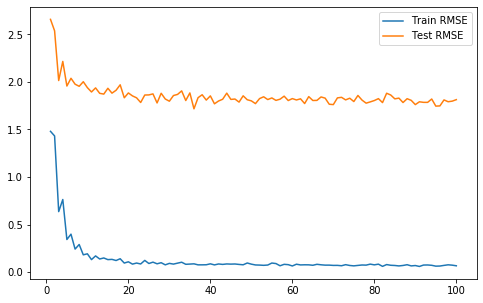

In [28]:
x_axis = np.arange(101)[1:]
plt.figure(figsize=(8,5))
plt.plot(x_axis, RMSE_train_list,label="Train RMSE")
plt.plot(x_axis, RMSE_test_list,label="Test RMSE")
plt.legend()
plt.show()

**2) Regularized**

In [0]:
RMSE_train_list = []
RMSE_test_list = []

for n_estimator in range(100):

  # to avoid n_estimator = 0
  n_estimator = n_estimator + 1

  model = AdaBoostRegressor(base_estimator=model_unr, n_estimators=n_estimator)
  model.fit(X_train,y_train)

  y_train_hat = model.predict(X_train)
  y_val_hat = model.predict(X_val)
  RMSE_train_list.append(RMSE(y_train,y_train_hat))
  RMSE_test_list.append(RMSE(y_val,y_val_hat))

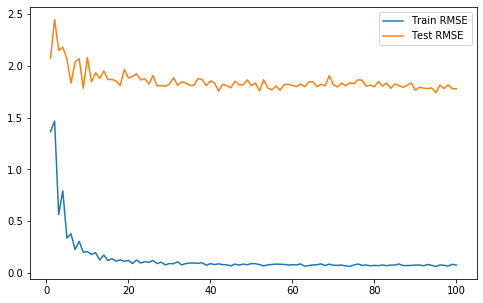

In [30]:
x_axis = np.arange(101)[1:]
plt.figure(figsize=(8,5))
plt.plot(x_axis, RMSE_train_list,label="Train RMSE")
plt.plot(x_axis, RMSE_test_list,label="Test RMSE")
plt.legend()
plt.show()

**f)** Pruebe otra técnica de ensamblado dedicada a árboles de decisión, que combina el muestreo boostrap de Bagging con muestreo sobre las features: Random Forest, compare el Árbol no regularizado con el regularizado ¿Se visualiza overfitting?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.

**1) Unregularized**

In [0]:
from sklearn.ensemble import RandomForestRegressor

RMSE_train_list = []
RMSE_test_list = []

for n_estimator in range(100):

  # to avoid n_estimator = 0
  n_estimator = n_estimator + 1

  model_unr = RandomForestRegressor(n_estimators=n_estimator, n_jobs=-1)
  model_unr.fit(X_train,y_train)

  y_train_hat = model_unr.predict(X_train)
  y_val_hat = model_unr.predict(X_val)
  RMSE_train_list.append(RMSE(y_train,y_train_hat))
  RMSE_test_list.append(RMSE(y_val,y_val_hat))

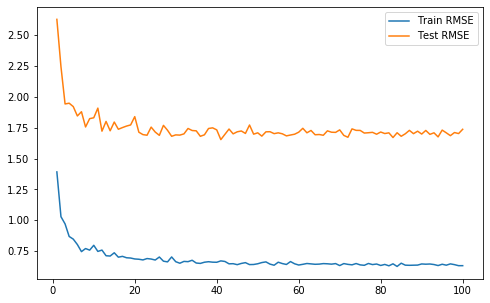

In [32]:
x_axis = np.arange(101)[1:]
plt.figure(figsize=(8,5))
plt.plot(x_axis, RMSE_train_list,label="Train RMSE")
plt.plot(x_axis, RMSE_test_list,label="Test RMSE")
plt.legend()
plt.show()

**2) Regularized**

In [0]:
RMSE_train_list = []
RMSE_test_list = []

for n_estimator in range(100):

  # to avoid n_estimator = 0
  n_estimator = n_estimator + 1

  model_reg = RandomForestRegressor(n_estimators=n_estimator, n_jobs=-1, max_depth=5, min_samples_split=5, max_leaf_nodes=14)
  model_reg.fit(X_train,y_train)

  y_train_hat = model_reg.predict(X_train)
  y_val_hat = model_reg.predict(X_val)
  RMSE_train_list.append(RMSE(y_train,y_train_hat))
  RMSE_test_list.append(RMSE(y_val,y_val_hat))


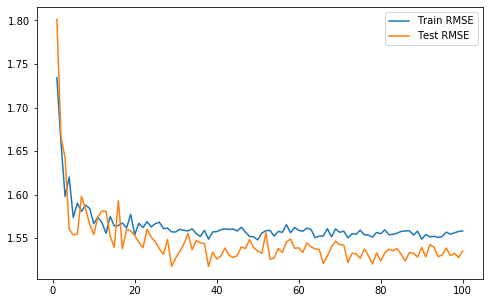

In [34]:
x_axis = np.arange(101)[1:]
plt.figure(figsize=(8,5))
plt.plot(x_axis, RMSE_train_list,label="Train RMSE")
plt.plot(x_axis, RMSE_test_list,label="Test RMSE")
plt.legend()
plt.show()

**g)** Verifique que el OOB error (out of bag error) de los ensambladores que utilizan la técnica boostrap puede ser una alternativa como métrica de generalización, compare con el error calculado sobre el conjunto de validación (o en su defecto cross validation).

**1) Unregularized**

In [0]:
# Unregularized model -- default parameters
model_unr = Tree()
model_unr.fit(X_train,y_train)

oob_error_train_list = []
val_error_list = []
no_estimators = np.arange(20, 50)
for n_estimator in no_estimators:

  n_estimator = n_estimator

  model = BaggingRegressor(base_estimator=model_unr, n_estimators=n_estimator, n_jobs=-1, oob_score=True)
  model.fit(X_train,y_train)

  y_train_hat = model.predict(X_train)
  y_val_hat = model.predict(X_val)
  oob_error_train_list.append(model.oob_score_)
  val_error_list.append(model.score(X_val,y_val))

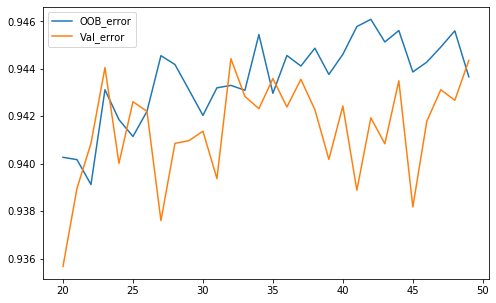

In [36]:
x_axis = np.arange(101)[1:]
plt.figure(figsize=(8,5))
plt.plot(no_estimators, oob_error_train_list,label="OOB_error")
plt.plot(no_estimators, val_error_list,label="Val_error")
plt.legend()
plt.show()

In [37]:
# Regularized tree model
model_reg = Tree(splitter='best', max_depth=5, min_samples_split=5, max_leaf_nodes=14)
model_reg.fit(X_train,y_train)

oob_error_train_list = []
val_error_list = []
no_estimators = np.arange(20, 50)
for n_estimator in no_estimators:

  n_estimator = n_estimator

  model = BaggingRegressor(base_estimator=model_reg, n_estimators=n_estimator, n_jobs=-1, oob_score=True)
  model.fit(X_train,y_train)

  y_train_hat = model.predict(X_train)
  y_val_hat = model.predict(X_val)
  oob_error_train_list.append(model.oob_score_)
  val_error_list.append(model.score(X_val,y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:1056: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


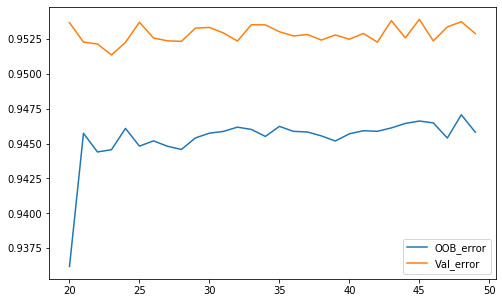

In [38]:
x_axis = np.arange(101)[1:]
plt.figure(figsize=(8,5))
plt.plot(no_estimators, oob_error_train_list,label="OOB_error")
plt.plot(no_estimators, val_error_list,label="Val_error")
plt.legend()
plt.show()

**h)** Defina otra forma de combinar los valores que entregan los ensamblados al hacer predicciones y compare con lo que se hace actualmente, por ejemplo Bagging realiza el voto de la mayoría para clasificación y promedio para regresión, AdaBoost realiza una combinación ponderada de cada clasificador dependiendo de su habilidad (desempeño para clasificar el conjunto de entrenamiento). Se puede inspirar desde clásicos estadísticos, como entregar el primer cuartíl ( 𝑄1 ) si al ensamblado le cuesta predecir valores bajos, o el segundo cuartil ( 𝑄2 ) o mediana para ser robusto a predicciones atípicas de modelos.

In [93]:
def combine_predictions(predictions):

  new_predictions = []

  df_list_predictions = pd.DataFrame(predictions)
  df_details = df_list_predictions.describe()

  for i in range(df_details.shape[1]):

    q1 = df_details[i]["25%"]
    q2 = df_details[i]["50%"]
    q3 = df_details[i]["75%"]

    q1_diff = abs(y_train[i] - q1)/float(y_train[i])
    q3_diff = abs(y_train[i] - q3)/float(y_train[i])

    if q1_diff > 0.5:

      new_predictions.append(q1)

    elif q3_diff > 0.5:

      new_predictions.append(q3)

    else:
      new_predictions.append(q2)

    return new_predictions

list_estimators = model.estimators_
list_predictions = [estimator.predict(X_val) for estimator in list_estimators]
new_predictions = combine_predictions(list_predictions)
print("RMSE val= ",RMSE(y_val, new_predictions))

RMSE val=  7.402322619458463


**i)** Si se cuenta con una gran cantidad de modelos en el ensamblado, por ejemplo  𝑇>100 , se puede crear un intervalo de confianza de la predicción a través de todos estos valores, asumiendo una distribución Normal centrada en la media muestral de las predicciones, con desviación estándar muestral en las predicciones. El intervalo de confianza entrega más información que un único valor puntual de predicción. Visualice un intervalo de confianza al 95% de probabilidad en la predicción a lo largo de la serie de tiempo de validación, comente. Al asumir una distribución Normal, también puede explorar el tomar como predicción del ensamblado el muestreo sobre la distribución Normal creada entorno a los datos muestrales.

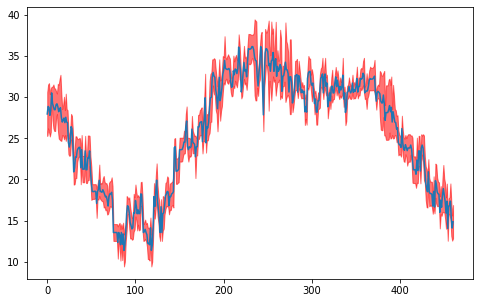

In [94]:
X_val_est = np.vstack(list_predictions).T #has shape=(N_test, n_estimator), with n_estimator>100
from scipy.stats import norm
interv_val = []
for n in range(X_val.shape[0]):
    low, up = norm.interval(0.95, loc=np.mean(X_val_est[n]), scale=np.std(X_val_est[n]))
    interv_val.append([low,up])
interv_val = np.asarray(interv_val)
x = np.arange(X_val_est.shape[0])
plt.figure(figsize=(8,5))
plt.plot(x, np.mean(X_val_est, axis=1))
plt.fill_between(x, interv_val[:,0], interv_val[:,1], color='r', alpha=.55)
plt.show()

**j)** Evalúe y visualice la predicción del mejor modelo encontrado para resolver este problema, en el conjunto de pruebas. Además, compare y analice las distintas maneras con las que se resolvió el problema, incluya las decisiones que conlleva y los resultados que reflejan.

In [0]:
df = pd.read_csv(url_test)
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row

#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['day'] = df['date'].dt.day
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.week
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
#any more information?
df.drop(["date"], axis=1, inplace=True) #delete date

y = df.pop("y_value").values
X = df.values 
X_test = X[:1000]
y_test = y[:1000]
X_test, y_test = shuffle(X_test, y_test, random_state=0) #shuffle values on train only

In [106]:
X_test

array([[31.        , 34.25      ,  2.1       , ...,  4.        ,
         1.        ,  0.        ],
       [11.        , 72.11111111,  9.77222222, ...,  1.        ,
         0.        ,  1.        ],
       [21.        , 69.96      ,  8.756     , ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [20.        , 42.44444444,  9.66666667, ...,  3.        ,
         1.        ,  0.        ],
       [21.3       , 64.4       ,  9.28      , ...,  2.        ,
         0.        ,  1.        ],
       [16.875     , 65.5       ,  6.9625    , ...,  2.        ,
         0.        ,  1.        ]])

In [0]:
model_reg = Tree(splitter='best', max_depth=5, min_samples_split=5, max_leaf_nodes=14)
model_reg.fit(X_test,y_test)

RMSE_test_list = []

for n_estimator in range(100):

  # to avoid n_estimator = 0
  n_estimator = n_estimator + 1

  model = BaggingRegressor(base_estimator=model_reg, n_estimators=n_estimator, n_jobs=-1)
  model.fit(X_test,y_test)

  y_test_hat = model.predict(X_test)
  RMSE_test_list.append(RMSE(y_test,y_test_hat))

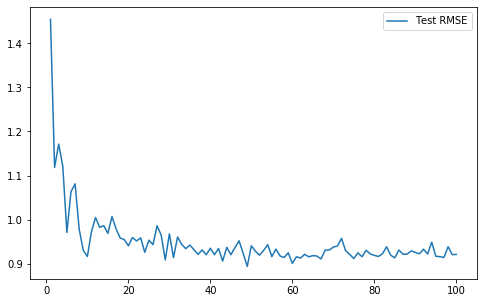

In [109]:
x_axis = np.arange(101)[1:]
plt.figure(figsize=(8,5))
plt.plot(x_axis, RMSE_test_list,label="Test RMSE")
plt.legend()
plt.show()

<a id="refs"></a>
## Referencias
[1] https://scikit-learn.org/stable/modules/ensemble.html  
[2] https://scikit-learn.org/stable/modules/tree.html  
[3] http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html  
[4] https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18